In [1]:
import spacy #for tokenization and lemmatization
nlp = spacy.load('en_core_web_sm')
lemmatizer = nlp.get_pipe("lemmatizer")

In [22]:
from scipy.stats import ttest_ind
import matplotlib.patches as mpatches
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

In [3]:
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet as wn #to use WordNet

[nltk_data] Downloading package wordnet to /home/jinhan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
import re #regular expression for removing punctuations
import requests #read the British to American dictionary
import pandas as pd
import csv

In [5]:
import json
british_to_american = json.load(open('../british_spellings.json'))

In [7]:
url ="https://raw.githubusercontent.com/hyperreality/American-British-English-Translator/master/data/british_spellings.json"
british_to_american = requests.get(url).json()

In [8]:
root = "/mnt/h/OneDrive - The University Of Hong Kong/bdd/explanations/"
file = "exp_vehicle_bdd.csv"
import os

exp = pd.read_csv(os.path.join(root, file)) #Read the file with explanation text
# Label: vehicle, human
# Category: person, rider, car, bus, truck
exp = exp.astype({'text':'string','image':'string','label':'string','category':'string'})
exp.head()

,Unnamed: 0,subject_no,Trial_Index_,block,text,block_sequence,block_name,block_num,path,image,trialID,label,category,number,lastBlockType
0,0,1,1,2,he is walking with legs,2.0,exp_car1,1,/Hum_ExpTask_Test1_deploy/results/001ET1,411.jpg,1,human,person,NaN,NaN
1,1,1,2,2,slim with legs and hand,2.0,exp_car1,1,/Hum_ExpTask_Test1_deploy/results/001ET1,608.jpg,2,human,person,NaN,NaN
2,2,1,3,2,human face,2.0,exp_car1,1,/Hum_ExpTask_Test1_deploy/results/001ET1,480.jpg,3,human,person,NaN,NaN
3,3,1,4,2,human cloth with hat,2.0,exp_car1,1,/Hum_ExpTask_Test1_deploy/results/001ET1,85.jpg,4,human,person,NaN,NaN
4,4,1,5,2,human back with t shirt,2.0,exp_car1,1,/Hum_ExpTask_Test1_deploy/results/001ET1,703.jpg,5,human,person,NaN,NaN


In [9]:
def preprocess(row):
    #TODO: how to handle trials skipped with empty explanation? shouldn't count it in when calculating score mean for this subject (Fine if we get 0 scores which has no effect when taking average?)
    if pd.isna(row['text']): return []

    # Clean trials where subject answer they didn't see the image
    for keywords in ["cannot","can't","no car","cant identify","cannot identify","can not identify","can't identify", "can't see","cant see",'barely see','cannot see','no see',"not see", "dont see", "hardly see", 'cammot see',"didnt see","dont really see","seems nobody","cnt see"]:
        if keywords in row['text'].lower():
            return []  

    string = re.sub(r'[^\w\s]', '', row['text']) #Remove punctuations
    sentence = nlp(string) #Apply Spacy
    lemma_list = [token.lemma_ for token in sentence] #Lemmatization
    am_list = [] #Empty list to put changed spellings
    for word in lemma_list:
        if word in british_to_american:
            am_list.append(british_to_american[word]) #Replace with American spelling if there is a difference
        else:
            am_list.append(word) #Just append the original word if there is no difference
    return am_list

exp['tokenized'] = exp.apply(lambda row: preprocess(row), axis = 1) #Process explanations
exp.head()

,Unnamed: 0,subject_no,Trial_Index_,block,text,block_sequence,block_name,block_num,path,image,trialID,label,category,number,lastBlockType,tokenized
0,0,1,1,2,he is walking with legs,2.0,exp_car1,1,/Hum_ExpTask_Test1_deploy/results/001ET1,411.jpg,1,human,person,NaN,NaN,"[he, be, walk, with, leg]"
1,1,1,2,2,slim with legs and hand,2.0,exp_car1,1,/Hum_ExpTask_Test1_deploy/results/001ET1,608.jpg,2,human,person,NaN,NaN,"[slim, with, leg, and, hand]"
2,2,1,3,2,human face,2.0,exp_car1,1,/Hum_ExpTask_Test1_deploy/results/001ET1,480.jpg,3,human,person,NaN,NaN,"[human, face]"
3,3,1,4,2,human cloth with hat,2.0,exp_car1,1,/Hum_ExpTask_Test1_deploy/results/001ET1,85.jpg,4,human,person,NaN,NaN,"[human, cloth, with, hat]"
4,4,1,5,2,human back with t shirt,2.0,exp_car1,1,/Hum_ExpTask_Test1_deploy/results/001ET1,703.jpg,5,human,person,NaN,NaN,"[human, back, with, t, shirt]"


In [10]:
def get_rating(item):
    rating = {}
    with open('/mnt/h/jinhan/emhmm/scripts/Jennifer/sensorimotor.csv') as file: #Read the file with sensorimotor strength ratings
        reader = csv.DictReader(file)
        for row in reader:
            rating[row['word']] = float(row[item]) #Convert ratings into dictionaries
    return rating

visual_dict = get_rating('visual')

In [11]:
def avg_rating(row, dict_name): #Calculate average rating per word for each explanation
    rating_list = []
    for lemma in row['tokenized']:
        lemma = lemma.upper()
        if lemma in dict_name:
            rating_list.append(dict_name[lemma])
    if len(rating_list) != 0:
        return sum(rating_list)/len(rating_list)
    else:
        return 0

In [12]:
exp['visual'] = exp.apply(lambda row: avg_rating(row, visual_dict), axis = 1) #Get visual strength for each explanation

exp.head()

,Unnamed: 0,subject_no,Trial_Index_,block,text,block_sequence,block_name,block_num,path,image,trialID,label,category,number,lastBlockType,tokenized,visual
0,0,1,1,2,he is walking with legs,2.0,exp_car1,1,/Hum_ExpTask_Test1_deploy/results/001ET1,411.jpg,1,human,person,NaN,NaN,"[he, be, walk, with, leg]",3.197386
1,1,1,2,2,slim with legs and hand,2.0,exp_car1,1,/Hum_ExpTask_Test1_deploy/results/001ET1,608.jpg,2,human,person,NaN,NaN,"[slim, with, leg, and, hand]",3.422308
2,2,1,3,2,human face,2.0,exp_car1,1,/Hum_ExpTask_Test1_deploy/results/001ET1,480.jpg,3,human,person,NaN,NaN,"[human, face]",4.836111
3,3,1,4,2,human cloth with hat,2.0,exp_car1,1,/Hum_ExpTask_Test1_deploy/results/001ET1,85.jpg,4,human,person,NaN,NaN,"[human, cloth, with, hat]",4.298203
4,4,1,5,2,human back with t shirt,2.0,exp_car1,1,/Hum_ExpTask_Test1_deploy/results/001ET1,703.jpg,5,human,person,NaN,NaN,"[human, back, with, t, shirt]",3.950868


In [13]:
wn_lemmas = set(wn.all_lemma_names()) #Get all lemmas in WordNet

def avg_similarity(row, col): #Calculate average similarity to the label for each explanation
    sim_list = []
    label = row[col]
    # if label == 'Tennis Ball': #Dealing with the special case of the two-word label, tennis ball
    #     label = 'tennis_ball'
    for lemma in row['tokenized']:
        if lemma in wn_lemmas: #Check if the word is in WordNet
            sim = wn.synsets(label)[0].path_similarity(wn.synsets(lemma)[0],simulate_root = False) #Disable simulate root so that we only get similarities for nouns
            if sim is not None: #For other parts of speech, similarity will be empty
                sim_list.append(sim)
    if len(sim_list) != 0:
        return sum(sim_list)/len(sim_list)
    else:
        return 0

In [14]:
exp['wordnet_similarity_label'] = exp.apply(lambda row: avg_similarity(row, 'label'), axis = 1) #Get WordNet similarity for each explanation
exp['wordnet_similarity_category'] = exp.apply(lambda row: avg_similarity(row, 'category'), axis = 1) #Get WordNet similarity for each explanation
exp.head()

,Unnamed: 0,subject_no,Trial_Index_,block,text,block_sequence,block_name,block_num,path,image,trialID,label,category,number,lastBlockType,tokenized,visual,wordnet_similarity_label,wordnet_similarity_category
0,0,1,1,2,he is walking with legs,2.0,exp_car1,1,/Hum_ExpTask_Test1_deploy/results/001ET1,411.jpg,1,human,person,NaN,NaN,"[he, be, walk, with, leg]",3.197386,0.051964,0.111195
1,1,1,2,2,slim with legs and hand,2.0,exp_car1,1,/Hum_ExpTask_Test1_deploy/results/001ET1,608.jpg,2,human,person,NaN,NaN,"[slim, with, leg, and, hand]",3.422308,0.051316,0.105556
2,2,1,3,2,human face,2.0,exp_car1,1,/Hum_ExpTask_Test1_deploy/results/001ET1,480.jpg,3,human,person,NaN,NaN,"[human, face]",4.836111,0.527778,0.112500
3,3,1,4,2,human cloth with hat,2.0,exp_car1,1,/Hum_ExpTask_Test1_deploy/results/001ET1,85.jpg,4,human,person,NaN,NaN,"[human, cloth, with, hat]",4.298203,0.379808,0.125926
4,4,1,5,2,human back with t shirt,2.0,exp_car1,1,/Hum_ExpTask_Test1_deploy/results/001ET1,703.jpg,5,human,person,NaN,NaN,"[human, back, with, t, shirt]",3.950868,0.292236,0.111219


In [15]:
exp.to_csv('../results/text_analysis/explanation_semantic_analysis_all.csv')

### Load Similarity Results

In [16]:
# remove trials in which subjects failed to detect
exp_preprocessed = exp[(exp['tokenized'].map(len) > 0) & ~(exp['tokenized'].map(lambda x: x[0] if len(x) > 0 else '') == ' ')]
exp_preprocessed['image'] = exp_preprocessed['image'].str.replace('.jpg', '')

/tmp/ipykernel_47140/662056848.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp_preprocessed['image'] = exp_preprocessed['image'].str.replace('.jpg', '')


In [17]:
exp_preprocessed.to_csv('../results/text_analysis/explanation_semantic_analysis_preprocessed.csv')

In [ ]:
exp_preprocessed[exp_preprocessed['label']].to_csv('../results/text_analysis/explanation_semantic_analysis_preprocessed.csv')

In [18]:
import pickle
PCC_all = pickle.load(open('/mnt/h/jinhan/xai/results/bdd/remove_empty_saliency/bdd_PCC_all.pickle','rb'))
RMSE_all = pickle.load(open('/mnt/h/jinhan/xai/results/bdd/remove_empty_saliency/bdd_PCC_all.pickle','rb'))

In [19]:
focused_analysis = ['DET vs FullGradCam','EXP vs ODAM']
categories = {
    'vehicle':"tab:blue",
    'human':'tab:orange'
}

measures = {
    'visual':"tab:blue",
    'wordnet_similarity_label':"tab:green",
    'wordnet_similarity_category':"tab:orange"
    }

visual vehicle 3.8879070413838677
visual human 3.6347523102092425


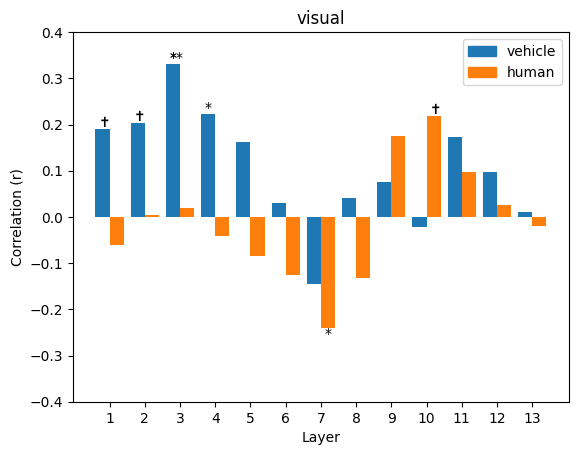

wordnet_similarity_label vehicle 0.09610320056686969
wordnet_similarity_label human 0.06167224539601847


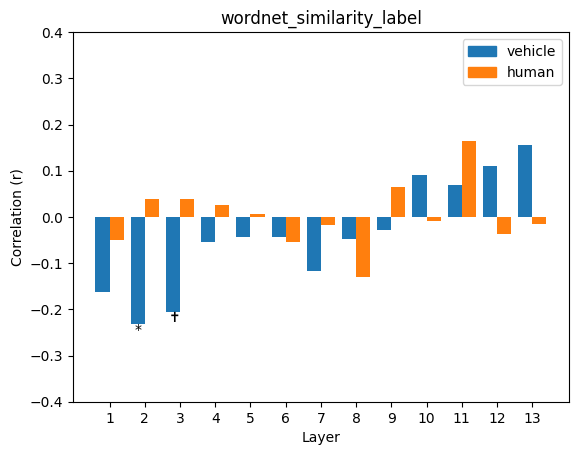

wordnet_similarity_category vehicle 0.1393529818886243
wordnet_similarity_category human 0.12376305317534349


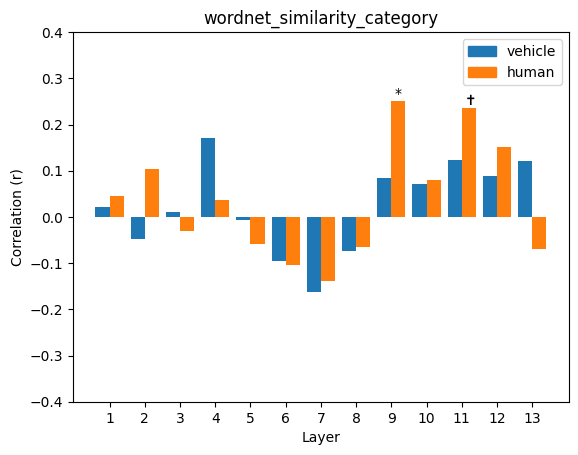

In [22]:
bar_width = 0.4

for m in measures:

    # Create a figure and a set of subplots
    fig, ax1 = plt.subplots()

    # Plot the positive bar plot on the primary y-axis
    ax1.set_xlabel('Layer')
    ax1.set_ylim(-0.4,0.4)
    ax1.set_ylabel('Correlation (r)')
    ax1.set_xticks(range(1,14))
    ax1.set_xticklabels(range(1,14))
    ax1.tick_params(axis='y')

    for c, color in categories.items():
        measure = exp_preprocessed[exp_preprocessed['label']==c].groupby("image",as_index=False)[m].mean()
        print(f"{m} {c} {measure[m].mean()}")
        
        PCC = PCC_all['EXP vs ODAM'][c]

        for layer in range(1,14):
            PCC_layer = PCC[18-layer]

            PCC_layer_df = pd.DataFrame(list(PCC_layer.items()), columns=['image', 'pcc'])

            merged_df = pd.merge(measure, PCC_layer_df, on='image')

            corr, p_value = pearsonr(merged_df[m],merged_df['pcc'])

            if c == 'vehicle':
                x = layer - bar_width/2
            else: x = layer + bar_width/2

            ax1.bar(x, corr, color=color, width=bar_width, label='Correlation (r)')
            if p_value < 0.01:
                ax1.annotate("**",(x-0.1,corr+0.005 if corr>0 else corr-0.02),color='black', label='p value')
            if p_value < 0.05:
                ax1.annotate("*",(x-0.1,corr+0.005 if corr>0 else corr-0.02),color='black', label='p value')
            elif p_value < 0.1:
                ax1.annotate("✝︎",(x-0.1,corr+0.005 if corr>0 else corr-0.02),color='black', label='p value')

    # Manually create custom legend entries
    positive_patch = mpatches.Patch(color='tab:blue', label='vehicle')
    negative_patch = mpatches.Patch(color='tab:orange', label='human')

    # Add custom legend
    plt.legend(handles=[positive_patch, negative_patch], loc='upper right')

    # Add a title
    plt.title(f'{m}')

    # Display the plot
    plt.show()

Mean

In [24]:
for m in measures:
    for c in categories:
        measure = exp_preprocessed[exp_preprocessed['label']==c][m].mean()
        print(f"{c} {m} {measure}")

vehicle visual 3.9071790887311573
human visual 3.661616625417049
vehicle wordnet_similarity_label 0.09654462503570169
human wordnet_similarity_label 0.06210074330591552
vehicle wordnet_similarity_category 0.1403035864046449
human wordnet_similarity_category 0.12428402238779335


t test (subject level)

In [29]:
for m in measures:
    veh = exp_preprocessed[exp_preprocessed['label']=='vehicle'].groupby("subject_no",as_index=False)[m].mean()[m]
    hum = exp_preprocessed[exp_preprocessed['label']=='human'].groupby("subject_no",as_index=False)[m].mean()[m]

    t_stat, p_value = ttest_ind(veh, hum)
    print(f"{m}: t stat = {t_stat}, p value = {p_value}")

visual: t stat = 2.8936614958991522, p value = 0.004536496255289341
wordnet_similarity_label: t stat = 9.445289122776652, p value = 4.1284226227093985e-16
wordnet_similarity_category: t stat = 1.2618584252304725, p value = 0.20948828790065158


t test (image level)

In [30]:
for m in measures:
    veh = exp_preprocessed[exp_preprocessed['label']=='vehicle'].groupby("image",as_index=False)[m].mean()[m]
    hum = exp_preprocessed[exp_preprocessed['label']=='human'].groupby("image",as_index=False)[m].mean()[m]

    t_stat, p_value = ttest_ind(veh, hum)
    print(f"t stat = {t_stat}, p value = {p_value}")

t stat = 8.917046308726023, p value = 3.832628443148663e-17
t stat = 28.067045111147117, p value = 4.649073883251917e-88
t stat = 4.461336136634954, p value = 1.1316119315393386e-05


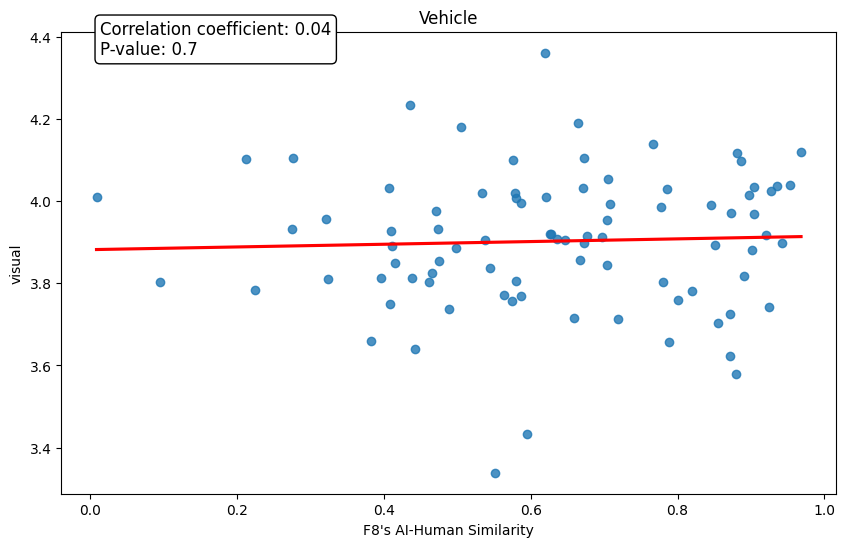

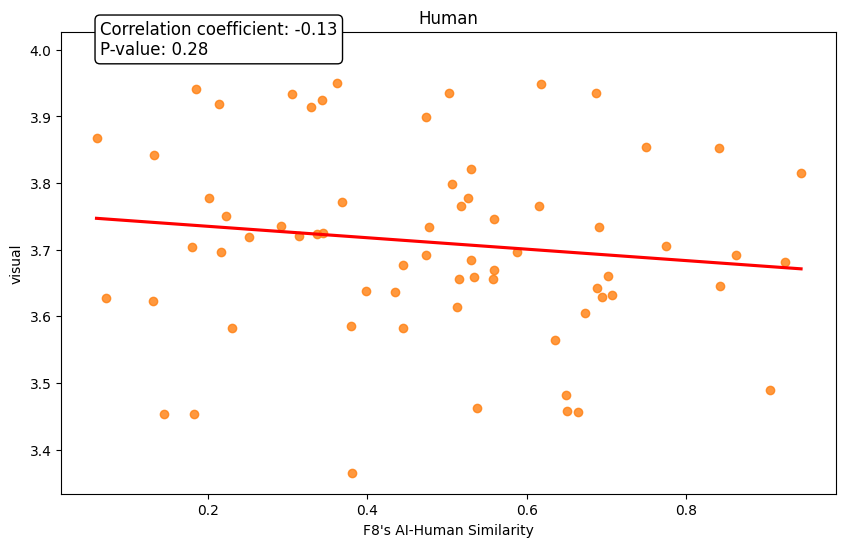

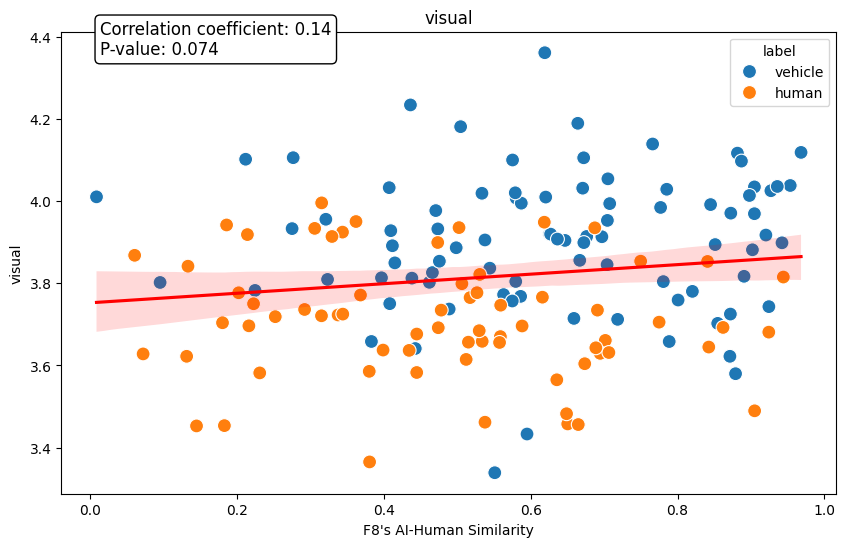

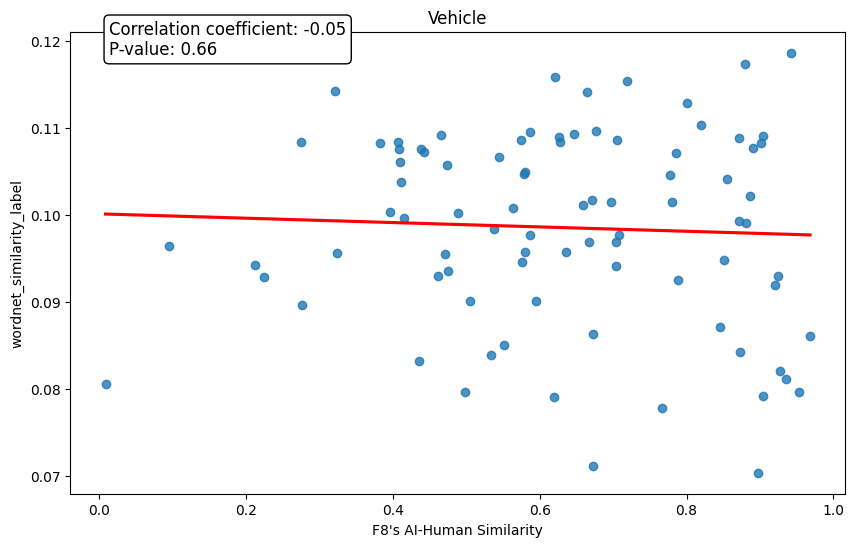

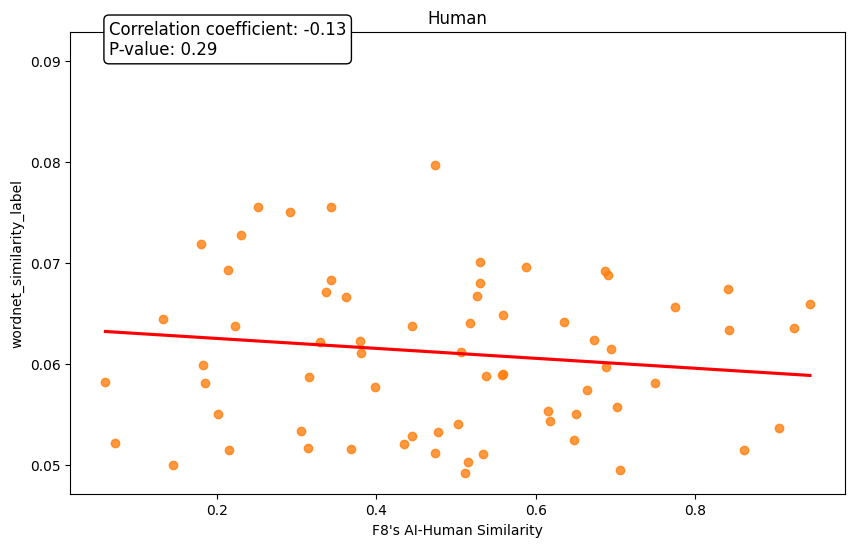

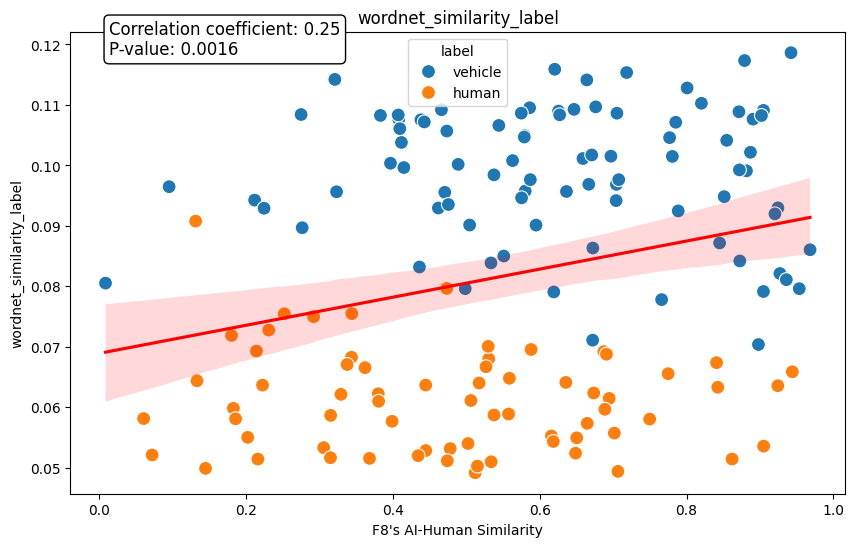

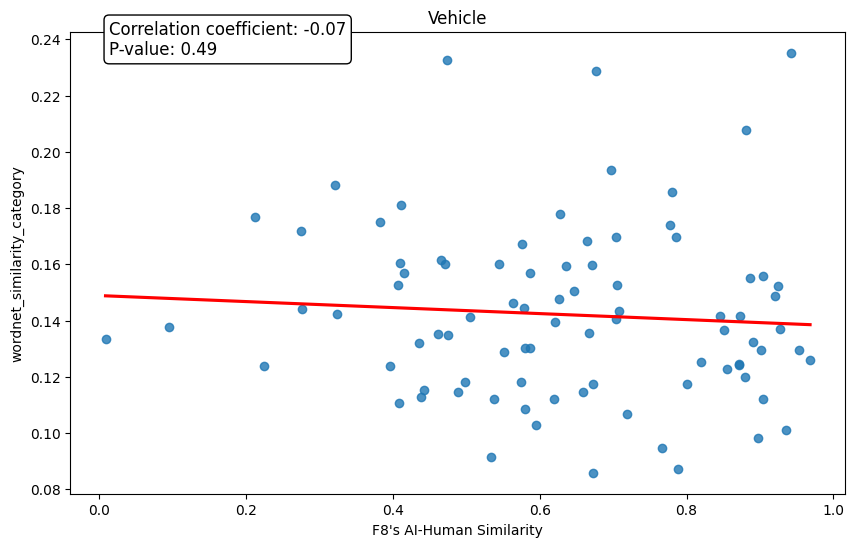

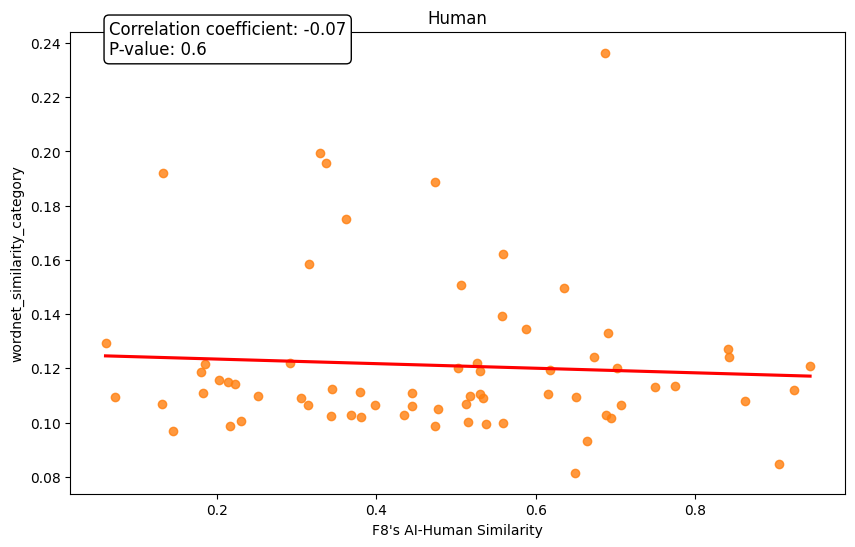

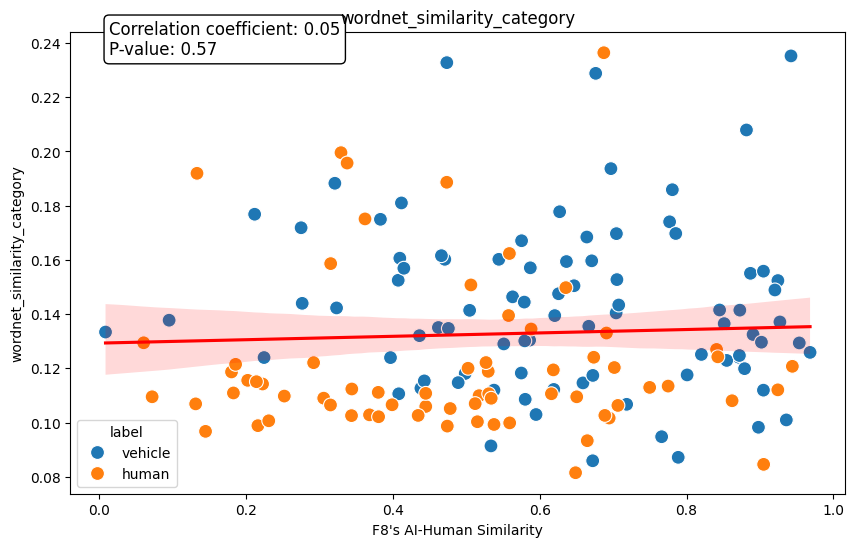

In [38]:
from scipy.stats import pearsonr
import seaborn as sns

for m in measures:    
    # veh
    PCC_layer = PCC_all['EXP vs ODAM']['vehicle'][18-8]
    PCC_layer_df_veh = pd.DataFrame(list(PCC_layer.items()), columns=['image', 'pcc'])

    measure = exp_preprocessed[exp_preprocessed['label']=='vehicle'].groupby("image",as_index=False)[m].mean()
    merged_df = pd.merge(measure, PCC_layer_df_veh, on='image')
    corr, p_value = pearsonr(merged_df[m],merged_df['pcc'])

    # Create the scatter plot with regression line
    plt.figure(figsize=(10, 6))
    sns.regplot(x='pcc', y=m, data=merged_df, ci=None, color="tab:blue",line_kws={"color": "red"})

    # Annotate the plot with correlation coefficient and p-value
    plt.annotate(f'Correlation coefficient: {corr:.2f}\nP-value: {p_value:.2g}',
                xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12,
                bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))
    # plt.xlim(0,200000)

    plt.xlabel("F8's AI-Human Similarity")
    plt.ylabel(m)
    plt.title('Vehicle')
    plt.show()

    # hum
    PCC_layer = PCC_all['EXP vs ODAM']['human'][18-8]
    PCC_layer_df_hum = pd.DataFrame(list(PCC_layer.items()), columns=['image', 'pcc'])

    measure = exp_preprocessed[exp_preprocessed['label']=='human'].groupby("image",as_index=False)[m].mean()
    merged_df = pd.merge(measure, PCC_layer_df_hum, on='image')
    corr, p_value = pearsonr(merged_df[m],merged_df['pcc'])

    # Create the scatter plot with regression line
    plt.figure(figsize=(10, 6))
    sns.regplot(x='pcc', y=m, data=merged_df, ci=None, color="tab:orange",line_kws={"color": "red"})

    # Annotate the plot with correlation coefficient and p-value
    plt.annotate(f'Correlation coefficient: {corr:.2f}\nP-value: {p_value:.2g}',
                xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12,
                bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))
    # plt.xlim(0,200000)

    plt.xlabel("F8's AI-Human Similarity")
    plt.ylabel(m)
    plt.title('Human')
    plt.show()

    # mix
    PCC_layer = PCC_all['EXP vs ODAM']['vehicle'][18-8]
    PCC_layer_df_veh['label'] = 'vehicle'
    PCC_layer_df_hum['label'] = 'human'
    PCC_layer_df_all = pd.concat([PCC_layer_df_veh, PCC_layer_df_hum])

    measure = exp_preprocessed.groupby(['label', 'image']).agg({m: 'mean'}).reset_index()
    merged_df = pd.merge(measure[['image',m,'label']], PCC_layer_df_all, on=['image', 'label'], how='right')
    corr, p_value = pearsonr(merged_df[m],merged_df['pcc'])

    # Create the scatter plot with regression line
    plt.figure(figsize=(10, 6))
    # Scatter plot with different colors based on category
    sns.scatterplot(x='pcc', y=m, data=merged_df, hue='label', s=100)
    # Regression line for all data points
    sns.regplot(x='pcc', y=m, data=merged_df, scatter=False, line_kws={"color": "red"})


    # Annotate the plot with correlation coefficient and p-value
    plt.annotate(f'Correlation coefficient: {corr:.2f}\nP-value: {p_value:.2g}',
                xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12,
                bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))
    # plt.xlim(0,200000)

    plt.xlabel("F8's AI-Human Similarity")
    plt.ylabel(m)
    plt.title(m)
    plt.show()

    

In [ ]:
import matplotlib.patches as mpatches
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

bar_width = 0.4

for m in measures:

    # Create a figure and a set of subplots
    fig, ax1 = plt.subplots()

    # Plot the positive bar plot on the primary y-axis
    ax1.set_xlabel('Layer')
    ax1.set_ylim(-0.4,0.4)
    ax1.set_ylabel('Correlation (r)')
    ax1.set_xticks(range(1,14))
    ax1.set_xticklabels(range(1,14))
    ax1.tick_params(axis='y')

    for c, color in categories.items():
        measure = exp_preprocessed[exp_preprocessed['label']==c].groupby("image",as_index=False)[m].mean()
        print(f"{m} {c} {measure[m].mean()}")
        
        PCC = PCC_all['EXP vs ODAM'][c]

        for layer in range(1,14):
            PCC_layer = PCC[18-layer]

            PCC_layer_df = pd.DataFrame(list(PCC_layer.items()), columns=['image', 'pcc'])

            merged_df = pd.merge(measure, PCC_layer_df, on='image')

            corr, p_value = pearsonr(merged_df[m],merged_df['pcc'])

            if c == 'vehicle':
                x = layer - bar_width/2
            else: x = layer + bar_width/2

            ax1.bar(x, corr, color=color, width=bar_width, label='Correlation (r)')
            if p_value < 0.01:
                ax1.annotate("**",(x-0.1,corr+0.005 if corr>0 else corr-0.02),color='black', label='p value')
            if p_value < 0.05:
                ax1.annotate("*",(x-0.1,corr+0.005 if corr>0 else corr-0.02),color='black', label='p value')
            elif p_value < 0.1:
                ax1.annotate("✝︎",(x-0.1,corr+0.005 if corr>0 else corr-0.02),color='black', label='p value')

    # Manually create custom legend entries
    positive_patch = mpatches.Patch(color='tab:blue', label='vehicle')
    negative_patch = mpatches.Patch(color='tab:orange', label='human')

    # Add custom legend
    plt.legend(handles=[positive_patch, negative_patch], loc='upper right')

    # Add a title
    plt.title(f'{m}')

    # Display the plot
    plt.show()